In [1]:
import json
import os
from os import listdir
from os.path import isfile, join
import pickle
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import tabulate
import numpy as np
import math

from itertools import cycle, islice

In [2]:
fig_width = 8
fig_height = 5

params = {
    'axes.labelsize': 16, # fontsize for x and y labels (was 10)
    'axes.titlesize': 16,
    'legend.fontsize': 16, # was 10
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': False,
    'figure.figsize': [fig_width,fig_height],
    'font.family': 'serif',
    'grid.linestyle': '--',
    'lines.linewidth': 2
}

matplotlib.rcParams.update(params)

In [31]:
data_dir = join('..', 'data', 'dataset_data')
exp_log_dir = join('..', 'data', 'aggregated_data-incremental_exp_cikm')
out_dir = join('..', 'plots', 'incremental_exp')


appname = 'LUBM'
data_size_dir = 'LUBM'
collections = ['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False

appname = 'BSBM'
data_size_dir = 'BSBM'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = True


appname = 'dyldo_y2019_core'
data_size_dir = 'DyLDO-core'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = False


appname = 'dyldo_y2019_full'
data_size_dir = 'DyLDO-ext'
collections =['schemex', 'attribute', 'type']
suffix = ''
hide_legend = True


ticks = 5.0
interpolate = True
include_title = False
legend_top = True
legend_wide =  False



clear_name = {'dyldo_y2019_core': 'DyLDO-core'}

drop the beat


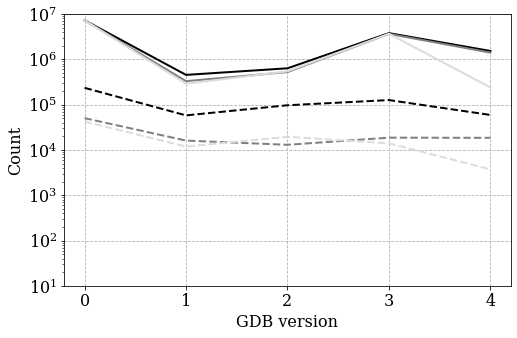

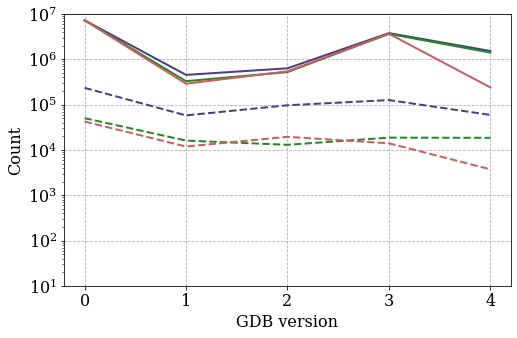

In [32]:
iterations = 0
plot_frame = pd.DataFrame() 
for collection in collections:
    with open(os.path.join(exp_log_dir, appname + '_'+collection+suffix+'-changes.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        iterations = max(iterations, len(df))
        f2 = open(os.path.join(exp_log_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r')
        df2 = pd.read_csv(f2, sep=',')
        df2.head()
        
        df2['Imprint links add-del'] = (df2['Imprint links'] - df2['Imprint links'].shift(1,fill_value=0)).abs()
        
        #plot_frame[collection+':change-ratio'] = ((df['ChangedSchemaStructures (SE_mod)'] +  df2['Imprint links add-del']) / (df2['Imprint links'].shift(1,fill_value=0)))
        plot_frame[collection+':changes'] = df['ChangedSchemaStructures (SE_mod)'] +  df2['Imprint links add-del']
        #plot_frame[collection+':update-ratio'] = (df['NewlyObservedSchema (SE_new)'] + df['DeletedSchemaStructures (SE_del)']) / df2['Schema Elements (SE)']
        plot_frame[collection+':updates'] = df['NewlyObservedSchema (SE_new)'] + df['DeletedSchemaStructures (SE_del)']

        
plot_frame.columns = ['SchemEX:changes', 'SchemEX:updates', 
                      'AttrColl:changes', 'AttrColl:updates', 
                      'TypeColl:changes', 'TypeColl:updates']

plot_frame.columns = ['SchemEX:changes', 'SchemEX:updates', 
                      'AttrColl:changes', 'AttrColl:updates', 
                      'ClassColl:changes', 'ClassColl:updates']

# this leads to line chart interpolating
# if appname == 'dyldo_y2019_core':
#     plot_frame = plot_frame.drop(plot_frame.index[[21,22]])

if appname == 'dyldo_y2019_core':
    if interpolate:
        plot_frame = plot_frame.drop(plot_frame.index[[21,22]])
    else:
        plot_frame.loc[21:22,'SchemEX:changes':'ClassColl:updates']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    #display(plot_frame)

if appname == 'dyldo_y2019_full':
    plot_frame = plot_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    

def plot_changes(bw_mode):    
    if bw_mode:
        ax = plot_frame.plot(logy=True, style=['-','--','-','--','-','--'], color=['black', 'black', 'grey', 'grey', 'gainsboro', 'gainsboro'])
    else:
        ax = plot_frame.plot(logy=True, style=['-','--','-','--','-','--'], color=['darkslateblue', 'darkslateblue', 'forestgreen', 'forestgreen', 'indianred', 'indianred'])

    
    ax.set_xlabel("GDB version")
    ax.set_ylabel("Count")
    if appname.startswith('dyldo'):
        ax.set_ylim([10, 10**7])
    else:
        ax.set_ylim(ymax=10**8)

    if include_title:
        if appname in clear_name:
            plt.title(clear_name[appname])
        else:
            plt.title(appname)

    plt.xticks(np.arange(0, iterations, ticks))
    
    if legend_top:
        # top
        if legend_wide:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), shadow=True, ncol=6)
        else:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), shadow=True, ncol=2)
        
    else:
        # right
        ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), shadow=True, ncol=1)
        
    plt.grid(True)

    if hide_legend:
        ax.get_legend().remove()
        
    if bw_mode:
        plt.savefig(out_dir + '/' + appname + '-change-ratio_bw.pdf', bbox_inches = 'tight')
        plt.savefig(out_dir + '/' + appname + '-change-ratio_bw.png', bbox_inches = 'tight', dpi=300)
    else:
        plt.savefig(out_dir + '/' + appname + '-change-ratio.pdf', bbox_inches = 'tight')
        plt.savefig(out_dir + '/' + appname + '-change-ratio.png', bbox_inches = 'tight', dpi=300)
    
plot_changes(True)
plot_changes(False)

drop the beat


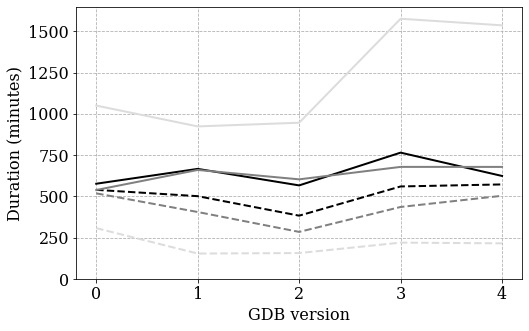

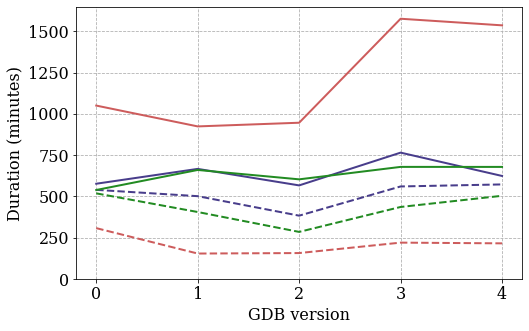

In [33]:
iterations = 0
performance_frame = pd.DataFrame() 
for collection in collections:
    with open(os.path.join(exp_log_dir, appname + '_'+collection+suffix+'-performance.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        #display(df.head())
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        performance_frame[collection + '-Inc'] = df['Total']
        performance_frame[collection + '-Batch'] = df['Batch']
        
    
    

performance_frame.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
             'AttrColl:Incr', 'AttrColl:Batch',
             'TypeColl:Incr', 'TypeColl:Batch']

performance_frame.columns = ['SchemEX:Incr', 'SchemEX:Batch', 
             'AttrColl:Incr', 'AttrColl:Batch',
             'ClassColl:Incr', 'ClassColl:Batch']


convert = lambda x: x / 1000 / 60
performance_frame = performance_frame.applymap(convert)  
#display(performance_frame)

if appname == 'dyldo_y2019_core':
    if interpolate:
        performance_frame = performance_frame.drop(performance_frame.index[[21,22]])
    else:
        performance_frame.loc[21:22,'SchemEX:Incr':'ClassColl:Batch']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    #display(performance_frame)
    
if appname == 'dyldo_y2019_full':
    performance_frame = performance_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    

def plot_performance(bw_mode):
    if bw_mode:
        ax = performance_frame.plot(logy=False, style = ['--','-','--','-','--','-'], color=['black', 'black', 'grey', 'grey', 'gainsboro', 'gainsboro'])
    else:
        ax = performance_frame.plot(logy=False, style = ['--','-','--','-','--','-'], color=['darkslateblue', 'darkslateblue',
                        'forestgreen', 'forestgreen', 'indianred', 'indianred'])
        
    ax.set_xlabel("GDB version")
    ax.set_ylabel("Duration (minutes)")

    ax.set_ylim(ymin=0)
    if appname == 'LUBM':
        ax.set_ylim(ymin=20)
        ax.set_ylim(ymax=50)
    #ax.yaxis.set_label_coords(-0.075,.9)

    if include_title:
        if appname in clear_name:
            plt.title(clear_name[appname])
        else:
            plt.title(appname)

    plt.xticks(np.arange(0, iterations, ticks))

    
    if legend_top:
        # top
        if legend_wide:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), shadow=True, ncol=6)
        else:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), shadow=True, ncol=2)
            
    else:
        # right
        ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.5), shadow=True, ncol=1)


    if hide_legend:
        ax.get_legend().remove()

    plt.grid(True)
    if bw_mode:
        plt.savefig(out_dir + '/' + appname + '-performance_bw.pdf', bbox_inches = 'tight')
        plt.savefig(out_dir + '/' + appname + '-performance_bw.png', bbox_inches = 'tight', dpi=300)
    else:
        plt.savefig(out_dir + '/' + appname + '-performance.pdf', bbox_inches = 'tight')
        plt.savefig(out_dir + '/' + appname + '-performance.png', bbox_inches = 'tight', dpi=300)
        
plot_performance(True)
plot_performance(False)

In [34]:
# performance_frame['AttrColl:Incr'].to_list()

In [44]:
alpha = 0.05

from scipy import stats

print('# %s performance' % appname)
def test_significance(performance_frame, col_a, col_b):
    # tStat, pValue = stats.ttest_rel(performance_frame[col_a].values, performance_frame[col_b].values) #run independent sample T-Test
    # print("[Dep] {} vs. {}, different sets (5%)? {}\n\t vsP-Value: {:.4f} T-Statistic: {:.4f}".format(col_a, col_b, pValue < alpha, pValue,tStat)) #print the P-Value and the T-Statistic
    tStat, pValue = stats.ttest_ind(performance_frame[col_a].values, performance_frame[col_b].values) #run independent sample T-Test
    print("+ [Independ T-Test] {} vs. {}, different sets (5%)? {}\n\t* vsP-Value: {:.4f} T-Statistic: {:.4f}".format(col_a, col_b, pValue < alpha, pValue,tStat)) #print the P-Value and the T-Statistic

 
test_significance(performance_frame, 'AttrColl:Incr', 'AttrColl:Incr')    
print('-----')
test_significance(performance_frame, 'AttrColl:Incr', 'ClassColl:Incr')    
test_significance(performance_frame, 'ClassColl:Incr', 'SchemEX:Incr')    
test_significance(performance_frame, 'SchemEX:Incr', 'AttrColl:Incr')    
print('-----')
test_significance(performance_frame, 'AttrColl:Incr', 'AttrColl:Batch')    
test_significance(performance_frame, 'ClassColl:Incr', 'ClassColl:Batch')    
test_significance(performance_frame, 'SchemEX:Incr', 'SchemEX:Batch')   


# dyldo_y2019_full performance
+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Incr, different sets (5%)? False
	* vsP-Value: 1.0000 T-Statistic: 0.0000
-----
+ [Independ T-Test] AttrColl:Incr vs. ClassColl:Incr, different sets (5%)? True
	* vsP-Value: 0.0024 T-Statistic: 4.3523
+ [Independ T-Test] ClassColl:Incr vs. SchemEX:Incr, different sets (5%)? True
	* vsP-Value: 0.0001 T-Statistic: -6.8002
+ [Independ T-Test] SchemEX:Incr vs. AttrColl:Incr, different sets (5%)? False
	* vsP-Value: 0.1687 T-Statistic: 1.5131
-----
+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Batch, different sets (5%)? True
	* vsP-Value: 0.0036 T-Statistic: -4.0610
+ [Independ T-Test] ClassColl:Incr vs. ClassColl:Batch, different sets (5%)? True
	* vsP-Value: 0.0001 T-Statistic: -6.7675
+ [Independ T-Test] SchemEX:Incr vs. SchemEX:Batch, different sets (5%)? True
	* vsP-Value: 0.0325 T-Statistic: -2.5819


# LUBM performance
+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Incr, different sets (5%)? False
	* vsP-Value: 1.0000 T-Statistic: 0.0000
-----
+ [Independ T-Test] AttrColl:Incr vs. ClassColl:Incr, different sets (5%)? True
	* vsP-Value: 0.0000 T-Statistic: 35.8808
+ [Independ T-Test] ClassColl:Incr vs. SchemEX:Incr, different sets (5%)? True
	* vsP-Value: 0.0000 T-Statistic: -41.8914
+ [Independ T-Test] SchemEX:Incr vs. AttrColl:Incr, different sets (5%)? True
	* vsP-Value: 0.0000 T-Statistic: -9.5359
-----
+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Batch, different sets (5%)? True
	* vsP-Value: 0.0000 T-Statistic: -7.6532
+ [Independ T-Test] ClassColl:Incr vs. ClassColl:Batch, different sets (5%)? True
	* vsP-Value: 0.0000 T-Statistic: -11.6379
+ [Independ T-Test] SchemEX:Incr vs. SchemEX:Batch, different sets (5%)? True
	* vsP-Value: 0.0000 T-Statistic: -14.4656

# BSBM performance

+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Incr, different sets (5%)? False
	* vsP-Value: 1.0000 T-Statistic: 0.0000
-----
+ [Independ T-Test] AttrColl:Incr vs. ClassColl:Incr, different sets (5%)? False
	* vsP-Value: 0.9302 T-Statistic: -0.0878
+ [Independ T-Test] ClassColl:Incr vs. SchemEX:Incr, different sets (5%)? False
	* vsP-Value: 0.0810 T-Statistic: -1.7673
+ [Independ T-Test] SchemEX:Incr vs. AttrColl:Incr, different sets (5%)? False
	* vsP-Value: 0.0689 T-Statistic: 1.8442
-----
+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Batch, different sets (5%)? False
	* vsP-Value: 0.8676 T-Statistic: -0.1673
+ [Independ T-Test] ClassColl:Incr vs. ClassColl:Batch, different sets (5%)? False
	* vsP-Value: 0.8963 T-Statistic: -0.1307
+ [Independ T-Test] SchemEX:Incr vs. SchemEX:Batch, different sets (5%)? True
	* vsP-Value: 0.0262 T-Statistic: -2.2659


# DyLDO-core performance

+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Incr, different sets (5%)? False
	 * vsP-Value: 1.0000 T-Statistic: 0.0000
-----
+ [Independ T-Test] AttrColl:Incr vs. ClassColl:Incr, different sets (5%)? False
	 * vsP-Value: 0.0515 T-Statistic: 1.9715
+ [Independ T-Test] ClassColl:Incr vs. SchemEX:Incr, different sets (5%)? True
	 * vsP-Value: 0.0052 T-Statistic: -2.8589
+ [Independ T-Test] SchemEX:Incr vs. AttrColl:Incr, different sets (5%)? False
	 * vsP-Value: 0.4006 T-Statistic: 0.8444
-----
+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Batch, different sets (5%)? True
	 * vsP-Value: 0.0000 T-Statistic: -26.5345
+ [Independ T-Test] ClassColl:Incr vs. ClassColl:Batch, different sets (5%)? True
	 * vsP-Value: 0.0000 T-Statistic: -21.6179
+ [Independ T-Test] SchemEX:Incr vs. SchemEX:Batch, different sets (5%)? True
	 * vsP-Value: 0.0000 T-Statistic: -23.7633

# dyldo_y2019_full performance
+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Incr, different sets (5%)? False
	* vsP-Value: 1.0000 T-Statistic: 0.0000
-----
+ [Independ T-Test] AttrColl:Incr vs. ClassColl:Incr, different sets (5%)? True
	* vsP-Value: 0.0024 T-Statistic: 4.3523
+ [Independ T-Test] ClassColl:Incr vs. SchemEX:Incr, different sets (5%)? True
	* vsP-Value: 0.0001 T-Statistic: -6.8002
+ [Independ T-Test] SchemEX:Incr vs. AttrColl:Incr, different sets (5%)? False
	* vsP-Value: 0.1687 T-Statistic: 1.5131
-----
+ [Independ T-Test] AttrColl:Incr vs. AttrColl:Batch, different sets (5%)? True
	* vsP-Value: 0.0036 T-Statistic: -4.0610
+ [Independ T-Test] ClassColl:Incr vs. ClassColl:Batch, different sets (5%)? True
	* vsP-Value: 0.0001 T-Statistic: -6.7675
+ [Independ T-Test] SchemEX:Incr vs. SchemEX:Batch, different sets (5%)? True
	* vsP-Value: 0.0325 T-Statistic: -2.5819


,|E|
0,82221979
1,82245640
2,82381421
3,106491385
4,105755426
5,82146001
6,98067880
7,101718845
8,105793038
9,100874304


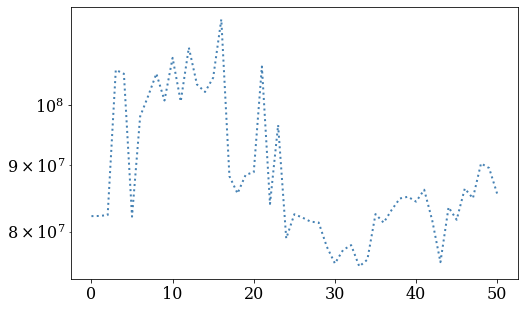

In [35]:
curr_dir = join(data_dir, data_size_dir)
#display(curr_dir)
onlyfiles = [f for f in listdir(curr_dir) if isfile(join(curr_dir, f)) and f.endswith(".txt")]
onlyfiles = sorted(onlyfiles)

#display(onlyfiles)
edgecounts = {}
tmp = 0
for filename in onlyfiles:
    # first line: number of types in dataset (not unique)
    # second line: number of edges in dataset (not unique)
    f = open(join(curr_dir,filename), 'r')
    content = f.read().split('\n')
    if len(content) > 2:
        edges = int(content[1])
    else:
        edges = int(content[0])
    if 'iteration' in filename:
        iteration = filename.replace('iteration', '')
        iteration = iteration.replace('-', '')
        iteration = iteration.replace('.txt', '')
        iteration = iteration.replace('.gz', '')
        iteration = iteration.replace('.nq', '')
        iteration = iteration.replace('.nt', '')
               
        edgecounts[int(iteration)] = edges
    else:
        edgecounts[tmp] = edges
        tmp = tmp + 1
     
    

edgeframe = pd.DataFrame.from_dict(edgecounts, orient='index')
edgeframe = pd.DataFrame.sort_index(edgeframe)

if appname == 'dyldo_y2019_core':
    if interpolate:
        edgeframe = edgeframe.drop(edgeframe.index[[21,22]])
    else:
        edgeframe.loc[21:22]=np.nan
 

###
ax = edgeframe.plot(logy=True, style = [':','-','--','-.',':','-','--','-.',':','-','--','-.'],
             color=['steelblue', 'steelblue', 'steelblue', 'steelblue','indianred','indianred','indianred','indianred']) # 'gray',
#ax.set_ylabel("Quantity")
#ax.yaxis.set_label_coords(-0.015,1.0)
#plt.xticks(np.arange(0, 50, 5.0))
#print("MAX: " + str(edgeframe.max()))
#print("MIN: " + str(edgeframe.min()))
#display(edgeframe)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), shadow=True, ncol=4)
if hide_legend:
    ax.get_legend().remove()
    
edgeframe.columns = ['|E|']
display(edgeframe)


In [36]:
size_frame = pd.DataFrame()
for collection in collections:
    with open(os.path.join(exp_log_dir, appname + '_'+collection+suffix+'-update-time-and-space.csv'), 'r') as f:
        df = pd.read_csv(f, sep=',')
        df.head()
        
        iterations = max(iterations, len(df['Iteration']))
        df = df.set_index('Iteration')

        if '|V|' not in size_frame:
            size_frame['|V|'] = df['Imprint links']
            
        size_frame[collection+':|V_vs|'] = df['Schema Elements (SE)']
        size_frame[collection+':|E_vs|'] = df['Schema Relations (SR)']


        
size_frame = size_frame.join(edgeframe,how='left')

if appname == 'dyldo_y2019_core':
    if interpolate:
        size_frame = size_frame.drop(size_frame.index[[21,22]])
    else:
        size_frame.loc[21:22,'|V|':'|E|']=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan

if appname == 'dyldo_y2019_full':
    size_frame = size_frame.head()
    iterations = 5
    ticks = 1.0
    print('drop the beat')
    
#display(size_frame)


drop the beat


In [37]:
size_frame

,|V|,schemex:|V_vs|,schemex:|E_vs|,attribute:|V_vs|,attribute:|E_vs|,type:|V_vs|,type:|E_vs|,|E|
Iteration,,,,,,,,
0,7271943,243423,1303004,50208.0,706205.0,42300.0,0.0,82221979
1,7509702,249691,1413856,54281.0,781832.0,39785.0,0.0,82245640
2,7064987,240266,1333850,52570.0,744073.0,39088.0,0.0,82381421
3,10592783,232566,1405716,56388.0,790516.0,31781.0,0.0,106491385
4,10440827,225972,1370282,55389.0,785474.0,31194.0,0.0,105755426


In [38]:
# NEW dataset statistics
print(f"Dataset: {appname}")
print(f"Mean degree: {(size_frame['|E|'] / size_frame['|V|']).mean()}")
print(f"Std degree: {(size_frame['|E|'] / size_frame['|V|']).std()}")

Dataset: dyldo_y2019_full
Mean degree: 10.820281732476586
Std degree: 0.7117258815603335


In [9]:
print(size_frame['|V|'].argmax())
print(size_frame['|V|'].argmin())
print(size_frame['|E|'].argmax())

4
7
0


In [28]:
print('Mean edges of the first 19 versions is %.4f' % size_frame.loc[0:18]['|E|'].mean())
print('Mean vertices of the first 19 versions is %.4f' % size_frame.loc[0:18]['|V|'].mean())


print('Mean edges of the first 20th versions is %.4f' % size_frame.loc[20]['|E|'].mean())
print('Mean vertices of the first 20th versions is %.4f' % size_frame.loc[20]['|V|'].mean())


print('Mean edges of the first 15 - 25 versions is %.4f' % size_frame.loc[15:25]['|E|'].mean())
print('Mean vertices of the first 15 - 25 versions is %.4f' % size_frame.loc[15:25]['|V|'].mean())



Mean edges of the first 19 versions is 11027374.3000
Mean vertices of the first 19 versions is 2165197.9000


KeyError: 20

In [29]:
display(size_frame['|V|'].min())
display(size_frame['|V|'].max())
display(size_frame['|V|'].mean())
display(size_frame['|V|'].std())

2152041

2174273

2165197.9

8642.501444090774

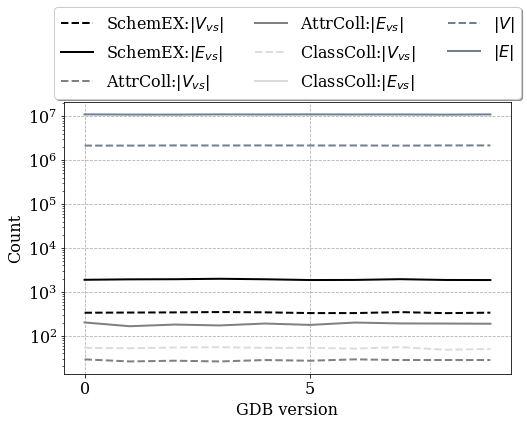

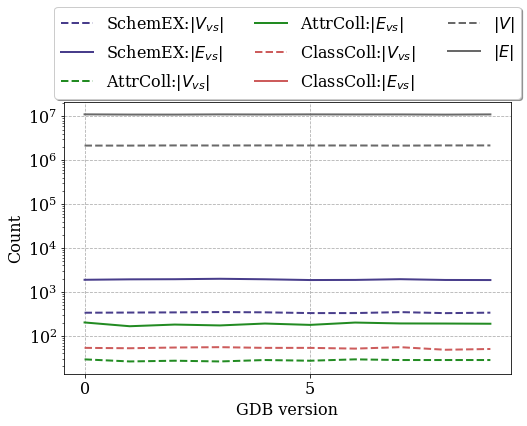

In [31]:
# size_frame.columns = ['|V|', 'SchemEX:|V_vs|','SchemEX:|E_vs|' 
#                     , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
#                     , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|E|']


# sorted_frame = size_frame[['SchemEX:|V_vs|', 'SchemEX:|E_vs|' 
#                     , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
#                     , 'TypeColl:|V_vs|', 'TypeColl:|E_vs|', '|V|', '|E|']]

# sorted_frame.columns=['SchemEX:$|V_{vs}|$', 'SchemEX:$|E_{vs}|$' 
#                     , 'AttrColl:$|V_{vs}|$', 'AttrColl:$|E_{vs}|$'
#                     , 'TypeColl:$|V_{vs}|$', 'TypeColl:$|E_{vs}|$', '$|V|$', '$|E|$']

size_frame.columns = ['|V|', 'SchemEX:|V_vs|','SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'ClassColl:|V_vs|', 'ClassColl:|E_vs|', '|E|']


sorted_frame = size_frame[['SchemEX:|V_vs|', 'SchemEX:|E_vs|' 
                    , 'AttrColl:|V_vs|', 'AttrColl:|E_vs|'
                    , 'ClassColl:|V_vs|', 'ClassColl:|E_vs|', '|V|', '|E|']]

sorted_frame.columns=['SchemEX:$|V_{vs}|$', 'SchemEX:$|E_{vs}|$' 
                    , 'AttrColl:$|V_{vs}|$', 'AttrColl:$|E_{vs}|$'
                    , 'ClassColl:$|V_{vs}|$', 'ClassColl:$|E_{vs}|$', '$|V|$', '$|E|$']


def plot_size(bw_mode):
    if bw_mode:
        colors=['black', 'black', 'grey', 'grey', 'gainsboro', 'gainsboro', 'slategrey', 'slategrey']
    else:
        colors=['darkslateblue', 'darkslateblue', 'forestgreen','forestgreen',
                                 'indianred','indianred', 'dimgray', 'dimgray']
    ax = sorted_frame.plot(logy=True, style = ['--','-','--','-','--','-','--','-'], 
                           color=colors)#,yticks=([math.exp(w) for w in np.arange(1, 10, 2)]))
    #ax.set_ylim([2500, 80000])color=['dimgray', 'darkslateblue']
    #plt.yticks(np.arange(0, iterations, 5.0))

    if include_title:
        if appname in clear_name:
            plt.title(clear_name[appname])
        else:
            plt.title(appname)

    plt.xticks(np.arange(0, iterations, ticks))
    ax.set_xlabel("GDB version")
    ax.set_ylabel("Count")
    if appname.startswith('dyldo'):
        ax.set_ylim([10**3, 10**8*2])

    if legend_top:
        # top        
        if legend_wide:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), shadow=True, ncol=8)
        else:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.38), shadow=True, ncol=3)
            
    else:
        # right
        ax.legend(loc='center right', bbox_to_anchor=(1.45, 0.5), shadow=True, ncol=1)
        
    if hide_legend:
        ax.get_legend().remove()

    plt.grid(True)
    if bw_mode:
        plt.savefig(out_dir + '/' + appname + '-sizes_bw.pdf',  bbox_inches = 'tight')
        plt.savefig(out_dir + '/' + appname + '-sizes_bw.png',  bbox_inches = 'tight', dpi=300)
    else:
        plt.savefig(out_dir + '/' + appname + '-sizes.pdf',  bbox_inches = 'tight')
        plt.savefig(out_dir + '/' + appname + '-sizes.png',  bbox_inches = 'tight', dpi=300)
        
        
plot_size(True)
plot_size(False)